In [1]:
import psycopg2
import pandas as pd 
# from sqlalchemy.types import Integer, Text, String, DateTime
import sqlalchemy as s
import matplotlib
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json

with open("config.json") as config_file:
    config = json.load(config_file)

database_connection_string = 'postgres+psycopg2://{}:{}@{}:{}/{}'.format(config['user'], config['password'], config['host'], config['port'], config['database'])

dbschema='augur_data'
engine = s.create_engine(
    database_connection_string,
    connect_args={'options': '-csearch_path={}'.format(dbschema)})

In [2]:
repo_list = pd.DataFrame()
repo_list_query = f"""
SELECT repo_id, repo_name, repo_path from repo
WHERE repo_name = 'BiG-CZ' OR repo_name = 'ADIOS' or repo_name = 'diana-hep' or repo_name = 'FingerPrint' or
      repo_name = 'ipop-project' or repo_name = 'open-source-dataturbine';
    """
repo_list = pd.read_sql_query(repo_list_query, con=engine)
print(repo_list)

   repo_id                repo_name                  repo_path
0    25498                   BiG-CZ                github.com/
1    25486                    ADIOS      github.com/ornladios/
2    25515                diana-hep                github.com/
3    25476              FingerPrint  github.com/rocksclusters/
4    25490             ipop-project                github.com/
5    25473  open-source-dataturbine        bitbucket.org/OSDT/


In [3]:
## List of repository IDs for the report

repo_dict = {25498} #BiG-CZ

In [4]:
#from datetime import date
import datetime 

current = datetime.date.today()
today = "'" + str(current) + "'"
#print(current)

first_current = current.replace(day=1)
last_month = first_current - datetime.timedelta(days=1)
end_date = "'" + str(last_month) + "'"
print(end_date)

start = last_month - datetime.timedelta(days=365)
start_date = "'" + str(start) + "'"
print(start_date)



'2021-01-31'
'2020-02-01'


In [5]:
from datetime import datetime, timezone

end_dt = datetime.strptime(end_date, "'%Y-%m-%d'").replace(tzinfo=timezone.utc)
print(end_dt)

start_dt = datetime.strptime(start_date, "'%Y-%m-%d'").replace(tzinfo=timezone.utc)
print(start_dt)



2021-01-31 00:00:00+00:00
2020-02-01 00:00:00+00:00


In [6]:
from datetime import datetime, timedelta, timezone

#now = datetime.now(timezone.utc)
#current = now.replace(hour=0, minute=0, second=0, microsecond=0)

#end_dt = current.replace(day=1) - timedelta(days=1)
print(end_dt)

#start_dt = end_dt - timedelta(days=365)
print(start_dt)

2021-01-31 00:00:00+00:00
2020-02-01 00:00:00+00:00


In [7]:
#Commit data - from humans excluding known bots
commitsDF = pd.DataFrame()
for value in repo_dict: 
    commitsquery = f"""
                    SELECT
                        DISTINCT(cmt_commit_hash),
                        contributors.cntrb_canonical,
                        canonical_full_names.cntrb_full_name AS canonical_full_name,
                        cmt_author_name, cmt_author_email, repo_id, cmt_author_timestamp 
                    FROM commits 
                        LEFT OUTER JOIN contributors ON cntrb_email = cmt_author_email left outer join 
                        (
                            SELECT distinct on (cntrb_canonical) cntrb_full_name, cntrb_canonical, data_collection_date
                            FROM contributors
                            WHERE cntrb_canonical = cntrb_email
                            order by cntrb_canonical
                        ) canonical_full_names on canonical_full_names.cntrb_canonical = contributors.cntrb_canonical
                    WHERE
                        repo_id = {value}
                        AND cmt_author_name NOT LIKE '%%utomation%%'
                        AND cmt_author_name NOT LIKE '%%ipeline%%'
                        AND cmt_author_name NOT LIKE '%%Cloud Foundry%%'
                        AND cmt_author_name NOT LIKE 'snyk%%'
                        AND cmt_author_name NOT LIKE '%%bot'
                        AND cmt_author_name NOT LIKE 'dependabot%%'
                        AND cmt_author_name NOT LIKE '%%Bot'
                        AND cmt_author_name NOT LIKE '%%BOT'
                        AND cmt_author_name != 'cfcr'
                        AND cmt_author_name != 'CFCR'
                        AND cmt_author_name != 'Travis CI'
                        AND cmt_author_name != 'Cloud Foundry London'
                        AND cmt_author_name != 'pivotal-rabbitmq-ci'
                        AND cmt_author_name != 'Bitnami Containers'
                        AND cmt_author_name != 'Spring Operator'
                        AND cmt_author_name != 'Spring Buildmaster'
--                      AND cmt_author_timestamp >= {start_date}
--                      AND cmt_author_timestamp <= {end_date}
                    ORDER BY
                        cntrb_canonical;
                    """
    
    get_repo_name_query = f"""
        SELECT repo_name from repo where repo_id = {value};
           """
    get_repo_name = pd.read_sql_query(get_repo_name_query, con=engine)
    repo_name = get_repo_name.repo_name[0]
    
all_commitsDF = pd.read_sql_query(commitsquery, con=engine)
commitsDF = all_commitsDF[(all_commitsDF['cmt_author_timestamp'] > start_dt) & (all_commitsDF['cmt_author_timestamp'] < end_dt)]
total_commits = commitsDF.cmt_commit_hash.nunique()  

In [8]:
authorDF = pd.DataFrame()
authorDF = commitsDF.cntrb_canonical.value_counts()
authorDF = authorDF.reset_index()
authorDF.columns = ['email', 'commits']
authorDF['percent'] = authorDF['commits'] / total_commits
print(authorDF.head(10))
print()

Empty DataFrame
Columns: [email, commits, percent]
Index: []



# Still Getting Data for this


In [9]:
authorDF = pd.DataFrame()
authorDF = commitsDF.canonical_full_name.value_counts()
#authorDF = commitsDF.cmt_author_name.value_counts()
authorDF = authorDF.reset_index()
authorDF.columns = ['name', 'commits']
authorDF['percent'] = authorDF['commits'] / total_commits
print(authorDF.head(10))

Empty DataFrame
Columns: [name, commits, percent]
Index: []


NameError: name 'risk_percent' is not defined

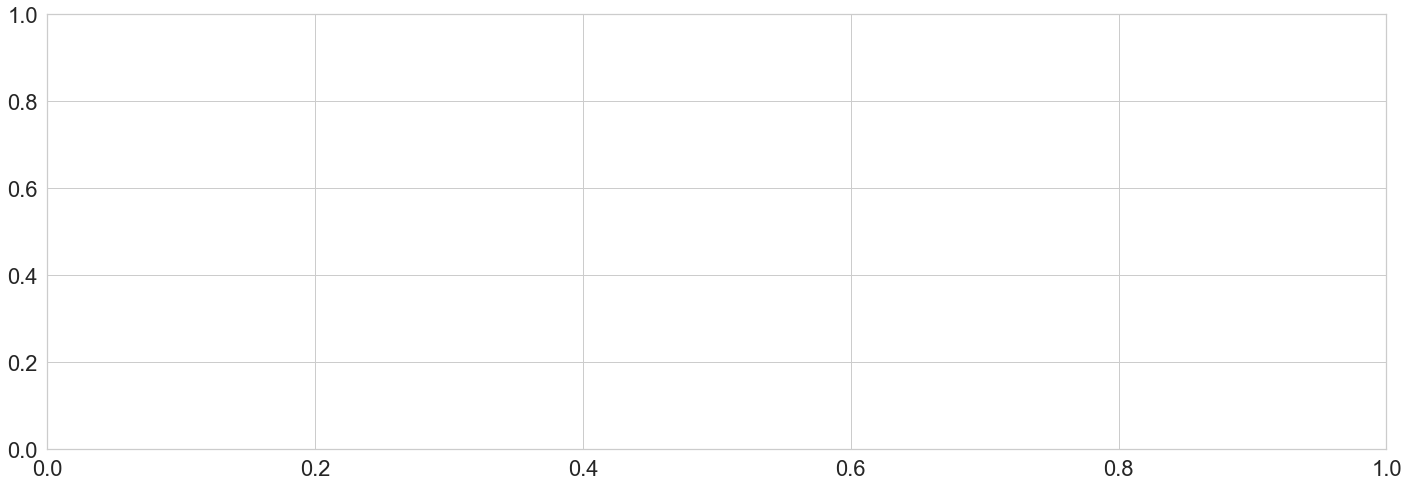

In [10]:
import textwrap

cum_percent = 0
people_list = []

i = 1
num_people = 0

for item in authorDF.iterrows():
    name = item[1]['name']
    percent = item[1]['percent']
    commits = item[1]['commits']
    
    cum_percent += percent
    
    people_list.append([name, percent, commits])
    
    if (cum_percent > .70 and num_people == 0):
        num_people = i
        risk_percent = cum_percent
        
    if i == 8:
        if cum_percent <= .70:
            risk_percent = cum_percent
            num_people = i
        break
    i+=1
    
risk_list = []
bar_colors = []

j = 1
for person in people_list:
    name = person[0]
    if len(name) > 15:
        new_name = textwrap.wrap(name, 15)
        name = '\n'.join(new_name)
    percent = person[1]
    commits = person[2]
    risk_list.append([name, percent, commits])
    
    if (num_people < 3 and j <= num_people):
        bar_colors.append('red')
    else:
        bar_colors.append('lightblue')
    
    j+=1
    

names = [item[0] for item in risk_list]
percents = [item[1] for item in risk_list]
commits = [item[2] for item in risk_list]

sns.set_style('ticks')
sns.set(style="whitegrid", font_scale=2)

fig, ax = plt.subplots()

# the size of A4 paper
fig.set_size_inches(24, 8)

title = repo_name + "\nContributor Risk Metric Assessment: "

if num_people < 3:
    title += "AT RISK"
    title_color = 'firebrick'
else:
    title += "Healthy"
    title_color = 'forestgreen'
title += "\n" + str(num_people) + " people made up " + "{:.0%}".format(risk_percent) + " of the commits in the past year.\n"

risk_bar = sns.barplot(x=names, y=commits, palette=bar_colors).set_title(title, fontsize=30, color=title_color)

risk_bar_labels = ax.set_xticklabels(names, wrap=True)
risk_bar_labels = ax.set_ylabel('Commits')
risk_bar_labels = ax.set_xlabel('\nKey Contributors\n\nA healthy project should have at a minimum 3 people who combined account for the majority (>50%) of the commits.\nThe higher this number is, the more likely your project would succeed if a leading contributor suddenly left the project.')

i = 0
for p in ax.patches:
    ax.annotate("{:.0%}".format(percents[i]), (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center', va='center', color='gray', xytext=(0, 20),
        textcoords='offset points')
    i+=1


In [11]:
from pathlib import Path
Path("output/tmp/tmp2").mkdir(parents=True, exist_ok=True)
fig.savefig('output/tmp/tmp2/test1.png')

## Misc data exploration
Trying to understand what's happening with the multiple canonical names

In [13]:
test = commitsDF.loc[commitsDF['cntrb_canonical'] == 's@goggins.com'].canonical_full_name
print(test[402])

IndexError: index out of bounds

In [ ]:
commitsDF.loc[commitsDF['cntrb_canonical'] == 's@goggins.com']